# **Smarter anomaly detection** - Data preparation step
*Part 1 - Data preparation*

## Initialization
---
This repository is structured as follow:

```sh
. smarter-anomaly-detection
|
├── data/
|   ├── interim                          # Temporary intermediate data are stored here
|   ├── processed                        # Finalized datasets ready to be moved to Amazon S3
|   └── raw                              # Immutable original data are stored here
|
└── notebooks/
    ├── 1_data_preparation.ipynb         <<< THIS NOTEBOOK <<<
    ├── 2_model_training.ipynb
    └── 3_model_evaluation.ipynb
```

### Notebook configuration update

In [2]:
!pip install --quiet --upgrade pip
!pip install --quiet --upgrade tqdm tsia kaggle

### Imports

In [4]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tsia
import zipfile

from matplotlib import gridspec
from tqdm import tqdm

### Parameters
Let's first check if the bucket name is defined, if it exists and if we have access to it from this notebook. If this notebook does not have access to the S3 bucket, you will have to update its permission:

In [3]:
RAW_DATA = os.path.join('..', 'data', 'raw')
TMP_DATA = os.path.join('..', 'data', 'interim')
PROCESSED_DATA = os.path.join('..', 'data', 'processed')
os.makedirs(RAW_DATA, exist_ok=True)
os.makedirs(TMP_DATA, exist_ok=True)
os.makedirs(PROCESSED_DATA, exist_ok=True)

%matplotlib inline
plt.style.use('fivethirtyeight')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.rcParams['lines.linewidth'] = 1.0

## Downloading data
---
We are going to use an industrial pump data available from Kaggle. To download this dataset from there, you will need to have an account and create a token that you install on your machine. You can follow [**this link**](https://www.kaggle.com/docs/api) to get started with the Kaggle API. Once generated, make sure your Kaggle token is stored in the `~/.kaggle/kaggle.json` file, or the next cells will issue an error. To get a Kaggle token, go to kaggle.com and create an account. Then click on your profile picture on the top right of the screen, select **Account** and scroll down to the API section. There, click the **Create new API token** button:

<img src="../../assets/kaggle_api.png" />

In [4]:
FILE_NAME    = 'pump-sensor-data.zip'
ARCHIVE_PATH = os.path.join(RAW_DATA, FILE_NAME)
FILE_PATH    = os.path.join(TMP_DATA, 'pump', 'sensor.csv')
FILE_DIR     = os.path.dirname(FILE_PATH)

if not os.path.isfile(FILE_PATH):
    if not os.path.exists('/home/ec2-user/.kaggle/kaggle.json'):
        os.makedirs('/home/ec2-user/.kaggle/', exist_ok=True)
        raise Exception('The kaggle.json token was not found.\nCreating the /home/ec2-user/.kaggle/ directory: put your kaggle.json file there once you have generated it from the Kaggle website')
    else:
        print('The kaggle.json token file was found: making sure it is not readable by other users on this system.')
        !chmod 600 /home/ec2-user/.kaggle/kaggle.json

    os.makedirs(os.path.join(TMP_DATA, 'pump'), exist_ok=True)
    !kaggle datasets download -d nphantawee/pump-sensor-data -p $RAW_DATA

    print("\nExtracting data archive")
    zip_ref = zipfile.ZipFile(ARCHIVE_PATH, 'r')
    zip_ref.extractall(FILE_DIR + '/')
    zip_ref.close()
    print('Done.')
    
else:
    print("File found, skipping download")

File found, skipping download


In [5]:
pump_df = pd.read_csv(FILE_PATH, sep=',')
pump_df.drop(columns={'Unnamed: 0'}, inplace=True)
pump_df['timestamp'] = pd.to_datetime(pump_df['timestamp'], format='%Y-%m-%d %H:%M:%S')
pump_df = pump_df.set_index('timestamp')

print('Shape:', pump_df.shape)
print('Original date range:')
print(' - from', np.min(pump_df.index), 'to', np.max(pump_df.index))
print(' - ', np.max(pump_df.index) - np.min(pump_df.index))
pump_df.head()

Shape: (220320, 53)
Original date range:
 - from 2018-04-01 00:00:00 to 2018-08-31 23:59:00
 -  152 days 23:59:00


,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


Amazon Lookout for Equipment needs at least 3 months of data to train on: this dataset has less than 3 months of data before the last failure present in the dataset. To get more interesting results, we are going to create an artificial time range by keeping the same datapoints but considering they have a 5-minute sampling rate instead of the original 1-minute one:

In [6]:
start_date = np.min(pump_df.index)
end_date = np.max(pump_df.index)
num_periods = pump_df.shape[0]

new_index = pd.date_range(end=end_date, periods=num_periods, freq='5min')
pump_df.index = new_index
pump_df.index.name = 'Timestamp'
print('New date range:')
print(' - from', np.min(pump_df.index), 'to', np.max(pump_df.index))
print(' - ', np.max(pump_df.index) - np.min(pump_df.index))
pump_df.head()

New date range:
 - from 2016-07-28 00:04:00 to 2018-08-31 23:59:00
 -  764 days 23:55:00


,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-07-28 00:04:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2016-07-28 00:09:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2016-07-28 00:14:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2016-07-28 00:19:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2016-07-28 00:24:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


## Dataset visualization
---

This dataset contains some labels with failure and healing periods:

In [7]:
broken_df = pump_df[pump_df['machine_status'] == 'BROKEN'].copy()

recovering_df = pd.DataFrame(index=pump_df.index, columns=['value'])
recovering_df['value'] = 0.0
recovering_index = pump_df[pump_df['machine_status'] == 'RECOVERING'].index
recovering_df.loc[recovering_index, 'value'] = 60.0

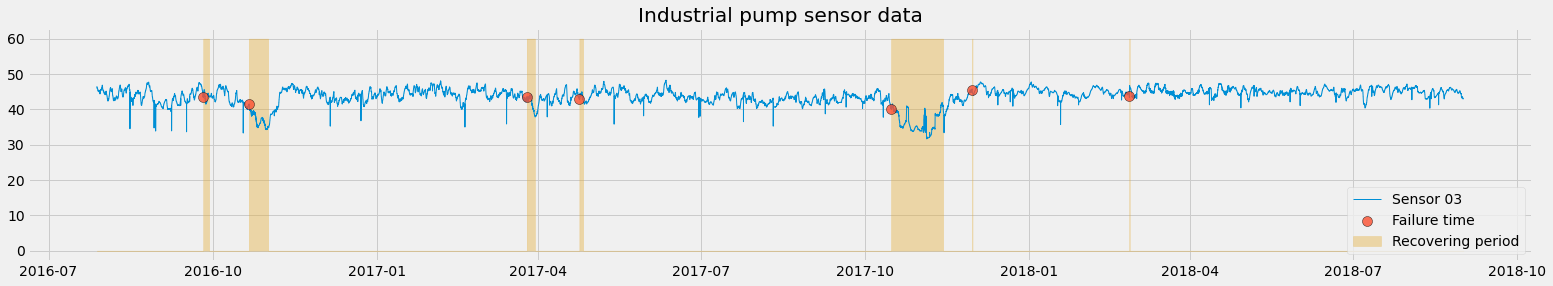

In [8]:
fig = plt.figure(figsize=(24,4))
plt.plot(pump_df['sensor_03'], label='Sensor 03')
plt.scatter(broken_df.index, broken_df['sensor_03'], marker='o', color=colors[1], s=100, edgecolor='#000000', alpha=0.8, zorder=3, label='Failure time')
plt.fill_between(x=recovering_df.index, y1=recovering_df['value'], color=colors[2], alpha=0.4, label='Recovering period')

plt.legend(loc='lower right')
plt.title('Industrial pump sensor data')

plt.show()

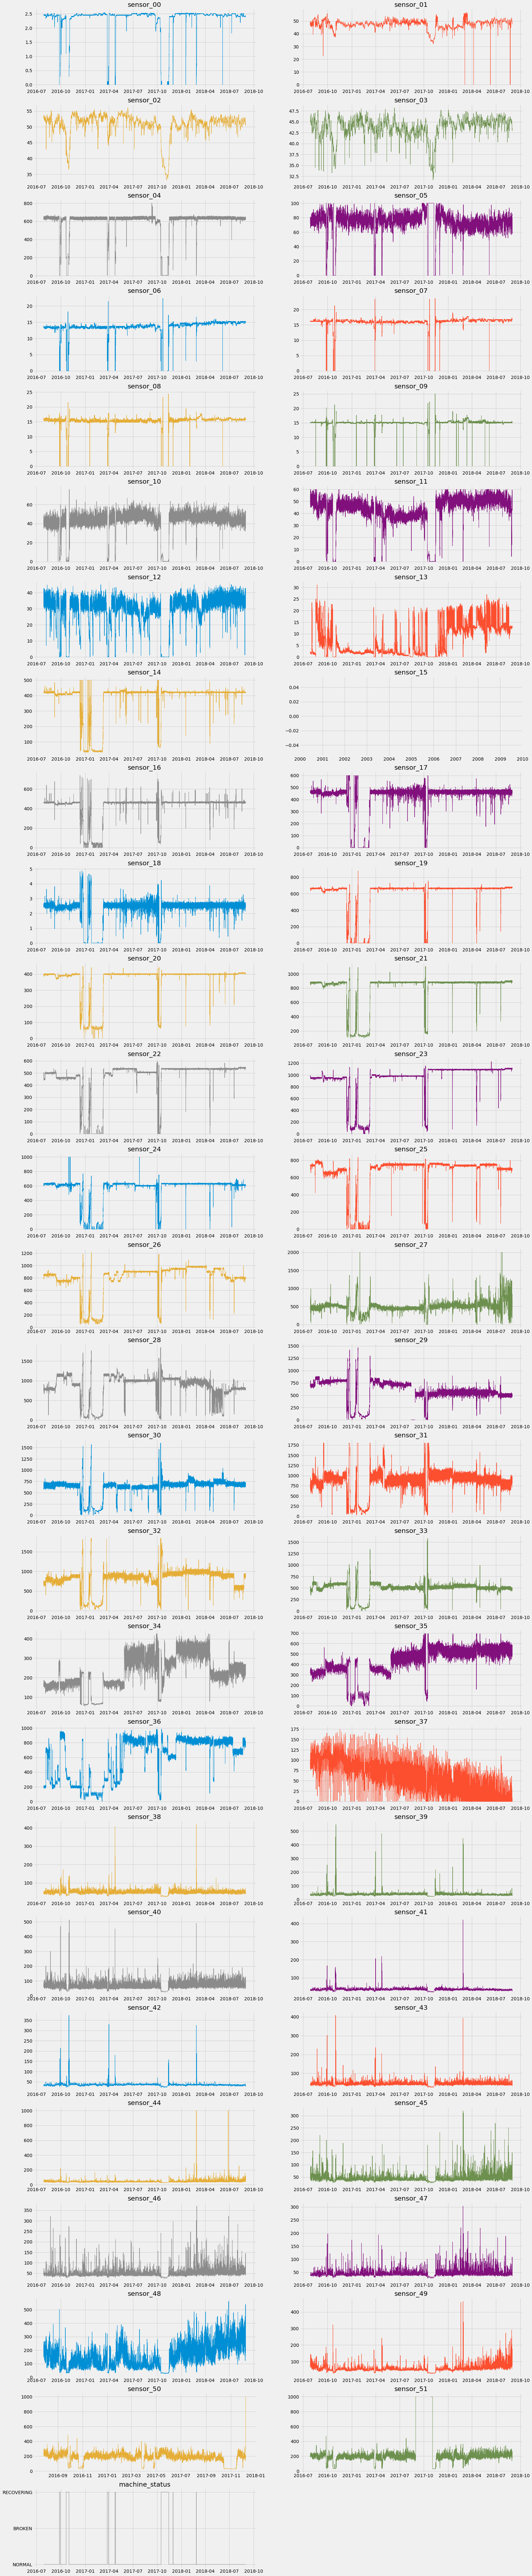

In [9]:
tags_list = list(pump_df.columns)
num_cols = 2
num_rows = len(tags_list) // num_cols + 1
fig = plt.figure(figsize=(24, 5 * num_rows))

for index, f in enumerate(tags_list):
    ax = fig.add_subplot(num_rows, num_cols, index+1)
    ax.plot(pump_df[f], color=colors[index % len(colors)])
    ax.set_title(f)
    
plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/tsia/plot/plot.py:500: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(signal_list, verticalalignment='bottom', fontsize=7)


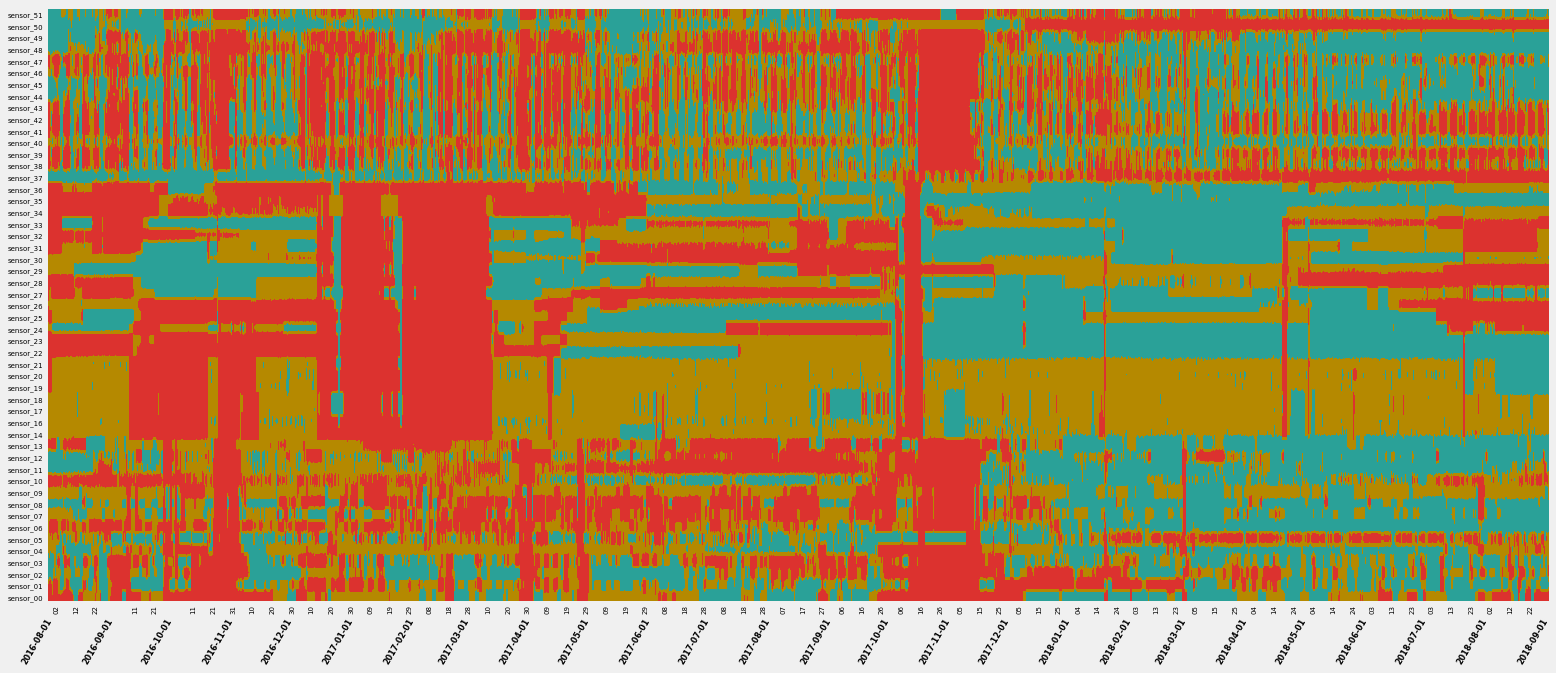

In [10]:
features = [f for f in tags_list if f not in ['sensor_15', 'machine_status']]

# Build a list of dataframes, one per feature:
df_list = []
for sensor in features:
    tag_df = pump_df[[sensor]]
    tag_df = tag_df.replace(np.nan, 0.0)
    df_list.append(tag_df)

# Discretize each signal in 3 bins:
array = tsia.markov.discretize_multivariate(df_list)

# Plot the strip chart:
tsia.plot.plot_timeseries_strip_chart(
    array, 
    signal_list=features,
    fig_width=24,
    signal_height=0.2,
    dates=df_list[0].index.to_pydatetime(),
    day_interval=10
)

## Preparing the dataset for ingestion
---
Let's now prepare the data for ingestion into the Amazon Lookout for Equipment service.

We need two datasets, the **time series data** and some **label** data: although Lookout for Equipment only uses unsupervised approaches, these label data are used to rank the models trained in the background and select the best one.

### Time series data

In [11]:
timeseries_df = pump_df[features]
timeseries_df.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-07-28 00:04:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
2016-07-28 00:09:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889
2016-07-28 00:14:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037
2016-07-28 00:19:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250
2016-07-28 00:24:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889


In [12]:
TRAIN_DATA = os.path.join(PROCESSED_DATA, 'train-data', 'pump')
os.makedirs(TRAIN_DATA, exist_ok=True)
timeseries_fname = os.path.join(TRAIN_DATA, 'sensors.csv')
timeseries_df.to_csv(timeseries_fname)

### Label data
We need to transform the label time series into a sequence of time ranges with start time and end time:

In [13]:
label_index = pump_df[
    (pump_df['machine_status'] == 'RECOVERING') | 
    (pump_df['machine_status'] == 'BROKEN')
].index

label_df = pd.DataFrame(index=pump_df.index, columns=['value'])
label_df['value'] = 0.0
label_df.loc[label_index, 'value'] = 1.0

label_df['previous'] = label_df.shift(1, fill_value=0.0)
label_df['start']    = (label_df['value'] == 1.0) & (label_df['previous'] == 0.0)
label_df['end']      = (label_df['value'] == 0.0) & (label_df['previous'] == 1.0)
label_df             = label_df[(label_df['start'] == True) | (label_df['end'] == True)]

anomaly_ranges = pd.DataFrame(columns=['start', 'end'])
for index, row in label_df.iterrows():
    if row['start'] == True:
        start = row.name
        
    if row['end'] == True:
        end = row.name
        anomaly_ranges = anomaly_ranges.append({'start': start, 'end': end}, ignore_index=True)
        
anomaly_ranges['start'] = anomaly_ranges['start'].dt.strftime('%Y-%m-%d %H:%M:%S')
anomaly_ranges['end'] = anomaly_ranges['end'].dt.strftime('%Y-%m-%d %H:%M:%S')
anomaly_ranges

,start,end
0,2016-09-25 13:39:00,2016-09-28 20:24:00
1,2016-10-21 02:34:00,2016-10-31 21:49:00
2,2017-03-25 16:34:00,2017-03-30 05:59:00
3,2017-04-24 02:34:00,2017-04-26 05:04:00
4,2017-10-15 14:04:00,2017-11-13 17:19:00
5,2017-11-30 00:59:00,2017-11-30 04:29:00
6,2018-02-25 22:04:00,2018-02-26 04:24:00


In [14]:
LABEL_DATA = os.path.join(PROCESSED_DATA, 'label-data')
os.makedirs(LABEL_DATA, exist_ok=True)
labels_fname = os.path.join(LABEL_DATA, 'labels.csv')
anomaly_ranges.to_csv(labels_fname, index=None, header=None)

### Uploading data to Amazon S3

In [15]:
BUCKET       = config.BUCKET
TRAIN_PREFIX = config.PREFIX_TRAINING
TRAIN_LABEL  = config.PREFIX_LABEL

s3_train_prefix = f's3://{BUCKET}/{TRAIN_PREFIX}water-pump/sensors.csv'
s3_label_prefix = f's3://{BUCKET}/{TRAIN_LABEL}labels.csv'

!aws s3 cp $timeseries_fname $s3_train_prefix
!aws s3 cp $labels_fname $s3_label_prefix

upload: ../data/processed/train-data/pump/sensors.csv to s3://lookout-equipment-poc/smarter-ad/training-data/water-pump/sensors.csv
upload: ../data/processed/label-data/labels.csv to s3://lookout-equipment-poc/smarter-ad/label-data/labels.csv


## Conclusion
---
In this notebook, you downloaded an industrial water pump dataset and prepared it for ingestion in Amazon Lookout for Equipment.

You also had a quick overview of the dataset with basic timeseries visualization.

You uploaded the training time series data and the anomaly labels to Amazon S3: in the next notebook of this getting started, you will be acquainted with the Amazon Lookout for Equipment API to create your first dataset and train a model